In [1]:
# Import libraries for generic data preprocessing
import os
import json
import shap
import numpy as np
import pandas as pd
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTEN

# Import libraries for preprocessing embeddings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sentence_transformers import SentenceTransformer

# Import libraries for classifying clusters based on embeddings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier

# Import libraries for clustering and topic classification
import hdbscan
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Set Random Seed

In [2]:
np.random.seed(10)
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

### Load Preprocessed Data

In [3]:
articles = pd.read_parquet('../data/proc_articles.gzip')
articles = articles.reset_index(drop=True)

In [4]:
articles.head()

,title,author,publication,content,party
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,Last weekend at church I confessed my sin of p...,right
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,The Times of Israel reports: An Israeli airst...,right
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,The Oracle Corporation is using its deep finan...,right
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,Apparently worried about the populist movement...,right
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,A severely dehydrated illegal alien called 911...,right


### Perform Stemming and Remove Stop Words

In [5]:
# Load in stop words, stemmer, and regex tokenizer
stop = stopwords.words('english')
punc = RegexpTokenizer(r'\w+')
# stemmer = PorterStemmer()

# Define function for de-lemmatizing words, removing whitespace, and stop words
def reformat_articles(w):
    # lowecase and remove stop words
    words = [word.lower() for word in w.split() if word.lower() not in stop]
    # remove punctuation
    words = [punc.tokenize(word) for word in words]
    # remove whitespace
    words = list(chain.from_iterable(words))
    # remove stems
    # words = [stemmer.stem(word) for word in words]  # TODO -- SEE IF IMPROVED AFTER DELETING THIS LINE
    # convert from list to string
    new_article = ' '.join(words)
    return new_article

# Apply lemmatization, whitespace removal, and stop word removal
articles['content'] = articles['content'].apply(reformat_articles)
articles.head()

,title,author,publication,content,party
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,last weekend church confessed sin personal van...,right
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,times israel reports israeli airstrike killed ...,right
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,oracle corporation using deep financial resour...,right
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,apparently worried populist movement led donal...,right
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,severely dehydrated illegal alien called 911 p...,right


### Embed Articles

In [6]:
# Load in pre-trained DistilBERT model
# DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased , runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [7]:
# Encode embeddings
embeddings = model.encode(articles['content'], show_progress_bar=True)

Batches:   0%|          | 0/1318 [00:00<?, ?it/s]

### Standardize Embeddings

In [8]:
# Perform mean-centering standardization on embeddings
std_embeddings = StandardScaler(with_mean=True).fit_transform(embeddings)

### Neighborhood-Based Dimensionality Reduction

In [9]:
# Perform non-linear dimensionality reduction
# The smaller the value, the more localized the dimensionality reduction
# The larger the value, the more globalized the dimensionality reduction
# n_neighbors = 15
# n_components = 5
# min_dist = 0.01
# metric = cosine
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.01, metric='cosine', random_state=42).fit_transform(std_embeddings)

# Perform min-max standardization on embeddings
std_umap_embeddings = MinMaxScaler().fit_transform(umap_embeddings)

### Density-Based Clustering

In [10]:
# Perform density-based clustering on dimensionality reduced embeddings
# The smaller the value, the more clusters returned
# The larger the value, the fewer clusters returned
# min_cluster_size=100
# metric=euclidean
cluster = hdbscan.HDBSCAN(min_cluster_size=100, metric='euclidean').fit(std_umap_embeddings)

In [11]:
# Frequencies of each cluster/label
unique, counts = np.unique(cluster.labels_, return_counts=True)
np.asarray((unique, counts)).T

array([[   -1, 13328],
       [    0,   457],
       [    1,   786],
       [    2,   120],
       [    3,   371],
       [    4,  1969],
       [    5,  4002],
       [    6,   249],
       [    7,   530],
       [    8,   261],
       [    9,   269],
       [   10,   571],
       [   11,   350],
       [   12,   113],
       [   13, 12238],
       [   14,   239],
       [   15,   252],
       [   16,  1399],
       [   17,   347],
       [   18,  1079],
       [   19,   188],
       [   20,   184],
       [   21,   339],
       [   22,   732],
       [   23,   650],
       [   24,  1127]])

### Plot Clusters

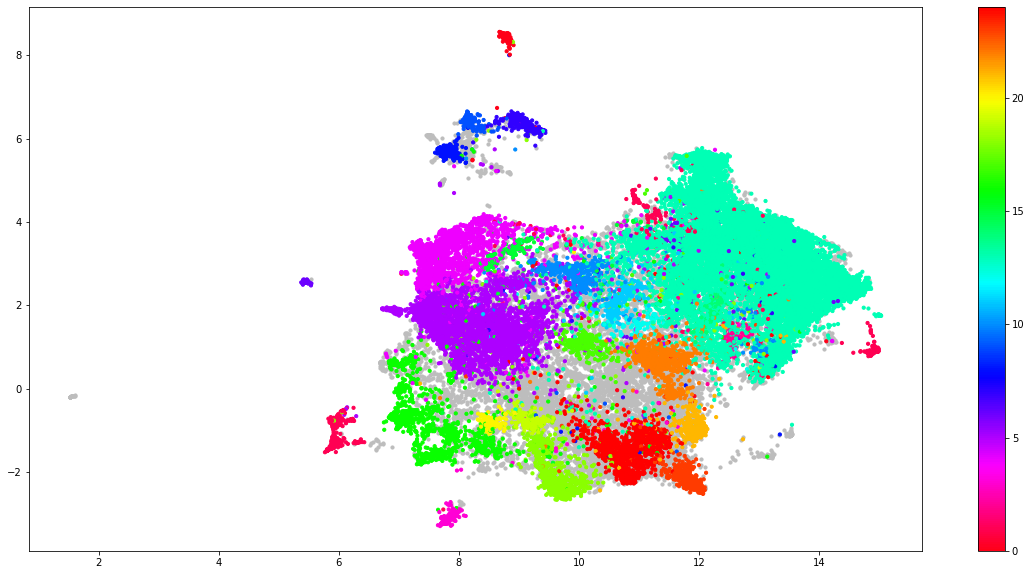

In [12]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.01, metric='cosine', random_state=27).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

### Defining Mapping of Topics

In [13]:
# Define mapping from cluster to topic
clust_map = {
    0: 'Baseball',
    1: 'Nuclear',
    2: 'Cuba Relations',
    3: 'Space',
    4: 'Terrorism and War',
    5: 'Crime',
    6: 'Brexit',
    7: 'Football',
    8: 'Olympics',
    9: 'Basketball',
    10: 'Protesting and Activism',
    11: 'LGBTQ Discrimination',
    12: 'Segregation and Racial Discrimination',
    13: 'Politics',
    14: 'U.S. Illegal Immigration',
    15: 'Nazism and Syrian Refugee Crisis',
    16: 'Global Warming',
    17: 'Technology and Data Privacy',
    18: 'Food',
    19: 'Medical Research',
    20: 'Widespread Disease',
    21: 'Real Estate',
    22: 'Business and Finance',
    23: 'Music',
    24: 'Pop Culture and Entertainment'
    }

### Build Topics JSON

In [14]:
# TODO -- Remove row filter from line 5
# Add cluster and embeddings to dataframe
articles['cluster'] = cluster.labels_
articles = articles.replace(clust_map)
articles['umap_embed1'] = umap_data[:,0]
articles['umap_embed2'] = umap_data[:,1]
topics = articles[articles['cluster'] != -1].reset_index(drop=True)
topics = topics.reset_index()

# Prepare dataframe for JSON formatting
topics = topics.rename(columns={'index': 'article_id'})
topics = topics[['article_id', 'publication', 'party', 'cluster', 'umap_embed1', 'umap_embed2']]
topics = topics[0:2]  # TODO -- Remove this row filter

# Convert dataframe to JSON
topics_str = topics.to_json(orient="records")
topics_json = json.loads(topics_str)
topics_json = json.dumps(topics_json, indent=4)

# Take a glimpse at JSON!
print(topics_json)

[
    {
        "article_id": 0,
        "publication": "Breitbart",
        "party": "right",
        "cluster": "Terrorism and War",
        "umap_embed1": 7.6847043037,
        "umap_embed2": 3.341915369
    },
    {
        "article_id": 1,
        "publication": "Breitbart",
        "party": "right",
        "cluster": "Politics",
        "umap_embed1": 12.8755130768,
        "umap_embed2": 1.7060809135
    }
]


### Get Top Words for each Topic

In [15]:
# Assign articles to topics
docs_df = pd.DataFrame(articles['content'])
docs_df['Topic'] = cluster.labels_
docs_df = docs_df[docs_df['Topic'] != -1]
docs_df['Doc_ID'] = range(len(docs_df))

# Rename columns
docs_df.columns = ['Doc', 'Topic', 'Doc_ID']
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic.head()

,Topic,Doc
0,0,miami ap person direct knowledge negotiations ...
1,1,international nuclear accord signed iran abrog...
2,2,sen jeff flake says president barack obama rig...
3,3,scientists said thursday first time detected g...
4,4,times israel reports israeli airstrike killed ...


In [16]:
# Compute c-TF-IDF scores for each word
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(articles['content']))
tf_idf[0:2]

array([[2.01347200e-03, 1.48274681e-04, 0.00000000e+00, 6.52322067e-05,
        6.44647633e-05, 9.03430674e-05, 1.70470773e-04, 0.00000000e+00,
        3.05059136e-04, 0.00000000e+00, 1.21703304e-04, 6.45961730e-05,
        1.83396567e-04, 3.12612591e-04, 1.39829872e-04, 0.00000000e+00,
        2.11348876e-04, 1.46737175e-04, 2.00165792e-05, 4.96427438e-05,
        5.73039820e-05, 7.04194779e-05, 1.03026164e-04, 1.92234750e-05,
        1.09749912e-05],
       [8.07814137e-04, 9.08551290e-04, 7.30773162e-04, 1.64642266e-03,
        1.77439673e-03, 1.39448440e-03, 1.41761385e-03, 7.87494117e-04,
        1.31292287e-03, 6.69764129e-04, 1.34350761e-03, 9.23561935e-04,
        7.75929675e-04, 1.02950619e-03, 2.35281600e-03, 2.95914086e-03,
        2.62090952e-03, 1.88389193e-03, 1.15058641e-03, 1.75268675e-03,
        3.11000367e-03, 3.96563981e-03, 3.94306712e-03, 6.00176285e-04,
        6.27658488e-04]])

In [17]:
# Extract top words for each topic
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = [{'topic': clust_map[label], 'top20_words': [{'word': words[j], 'tfidf': tf_idf_transposed[i][j]} for j in indices[i]][::-1]} for i, label in enumerate(labels)]
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
top_n_words

[{'topic': 'Baseball',
  'top20_words': [{'word': 'mets', 'tfidf': 0.026877324097796057},
   {'word': 'yankees', 'tfidf': 0.025945868048677555},
   {'word': 'baseball', 'tfidf': 0.01850179271297168},
   {'word': 'game', 'tfidf': 0.01612774451237032},
   {'word': 'season', 'tfidf': 0.01409456787280304},
   {'word': 'cubs', 'tfidf': 0.013302350373005988},
   {'word': 'innings', 'tfidf': 0.011392720954097716},
   {'word': 'games', 'tfidf': 0.011112108499799447},
   {'word': 'league', 'tfidf': 0.010706047821673486},
   {'word': 'players', 'tfidf': 0.009440662924812465},
   {'word': 'inning', 'tfidf': 0.008836579249453597},
   {'word': 'sox', 'tfidf': 0.007990999780282724},
   {'word': 'team', 'tfidf': 0.007895120763281678},
   {'word': 'field', 'tfidf': 0.007625623259327921},
   {'word': 'runs', 'tfidf': 0.007525789799817961},
   {'word': 'girardi', 'tfidf': 0.0074050519992552135},
   {'word': 'pitcher', 'tfidf': 0.007291349675533735},
   {'word': 'series', 'tfidf': 0.007220660055920209},


### Build TF-IDF JSON

In [18]:
# Convert dictionary to JSON
tfidf_json = json.dumps(top_n_words, indent=4)

# Take a glimpse at JSON!
print(tfidf_json)

[
    {
        "topic": "Baseball",
        "top20_words": [
            {
                "word": "mets",
                "tfidf": 0.026877324097796057
            },
            {
                "word": "yankees",
                "tfidf": 0.025945868048677555
            },
            {
                "word": "baseball",
                "tfidf": 0.01850179271297168
            },
            {
                "word": "game",
                "tfidf": 0.01612774451237032
            },
            {
                "word": "season",
                "tfidf": 0.01409456787280304
            },
            {
                "word": "cubs",
                "tfidf": 0.013302350373005988
            },
            {
                "word": "innings",
                "tfidf": 0.011392720954097716
            },
            {
                "word": "games",
                "tfidf": 0.011112108499799447
            },
            {
                "word": "league",
                "tfidf":

### Classify Topics based on Embeddings

In [19]:
# Prepare data for XGBoost training
idx = cluster.labels_ != -1
y = cluster.labels_[idx]
X = embeddings[idx]

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y
    )

In [21]:
# Get same number of randomly chosen test indices
idx = []
min_lab = min(Counter(y_test).values())
for i in np.unique(y_test):
    idx.extend(np.random.choice(np.where(y_test==i)[0], min_lab, replace=False))

# Enforce similar frequency of labels in test data
X_test = X_test[idx]
y_test = y_test[idx]

In [22]:
# Try undersampling to 1000 articles for each cluster
large_c = [c for c, count in Counter(y_train.tolist()).items() if count >= 1000]
small_c = [c for c, count in Counter(y_train.tolist()).items() if count < 1000]
idx = np.where(np.isin(y_train, small_c))[0].tolist()
for i in large_c:
    idx.extend(np.random.choice(np.where(y_train==i)[0], 1000, replace=False))

# Enforce similar frequency of labels in training data
X_train = X_train[idx]
y_train = y_train[idx]

In [23]:
# Initialize SMOTEN object for oversampling nominal features
sampler = SMOTEN(random_state=12)

# Simulate oversampled data for imbalanced classes
X_res, y_res = sampler.fit_resample(X_train, y_train)

# Check previous work!
print(Counter(y_res))

In [36]:
%%time
# Build xgboost model to predict topics based on embeddings
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
model = xgb.fit(X_res, y_res, eval_metric=['mlogloss'])

CPU times: user 39min 33s, sys: 6.84 s, total: 39min 40s
Wall time: 19min 58s


### Generate SHAP Values

In [40]:
# Make predictions on test data
preds = model.predict(X_test)

# Test model accuracy
round((preds == y_test).sum().astype(float) / len(preds)*100, 2)

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 33.7 ms


90.59

In [ ]:
# Plot feature importance
def plot_feature_importance(feature_names, shap_values):
 # Get the mean absolute contribution for each feature
 aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
 # sort by magnitude
 z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)]
 z = list(zip(*z))
 plt.bar(z[0], z[1])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()


plot_feature_importance(feature_names, shap_values)

In [ ]:
# # Use shap to determine top-3 embeddings
# explainer = shap.Explainer(model, X_res)
# shap_values = explainer(X_res)

# Visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

# assign those 3 embeddings on articles dataframe
# articles['bert_embed1'] = embeddings[:,10]
# articles['bert_embed2'] = embeddings[:,57]
# articles['bert_embed3'] = embeddings[:,24]

# plot top-3 embeddings3-dimensional graph and color each point with their topic
# plt.scatter(articles[bert_embed1], articles[bert_embed2], articles[bert_embed3], color=articles[topic])

# References
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# https://github.com/slundberg/shap#tree-ensemble-example-xgboostlightgbmcatboostscikit-learnpyspark-models
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/text.html#text-plot
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Exact.html#Tabular-data-with-partition-(Owen-value)-masking